Welcome to the coding demonstration from the Plant Cell Atlas. As you can see, you are running a Jupyter Notebook through Google Colab, a free service from Google. A Jupyter Notebook is a useful coding tool that allows you to run code in small blocks, which can be helpful for data science  where you make a lot of small changes and need to see the results midway through. You also have markdown blocks, like this one, which you can use to make headings and other text descriptions. IDEs will even let you jump between headings like bookmarks. 

---

While we are currently on Google Colab, you can also run Jupyter Notebooks locally or on a remote server. 

---

Although Jupyter Notebooks are very useful tools, its important to keep in mind that they have some drawbacks. Code blocks are executed in the order you run them, and can be executed multiple times or in arbitrary orders, so if you aren't careful you can end up making unintentional changes to your code without even realizing it. You should make sure you run cells in the order they are in your notebook to ensure your codes works as you expect it to. 

First, we will look at some heading sizes available. These are done by putting a number sign "#" at the start of the line. More "#" makes the heading smaller

# Markdown Heading 1 

## Markdown Heading 2 

### Markdown Heading 3 

You can also **bold text** put putting double asterisks around it, and *italicize* with single asterisks, and almost any other text or table formatting. You can also easily insert links, do quotes, and insert images. 

---

Double click on this box to see the source text

In [50]:
# Number signs set off comments in Python. Below we use "!" to run shell commands from within a Jupyter notebook cell.
# We are fetching our data and installing packages we need. 

!pip install scanpy
!pip install leidenalg
!mkdir data
!wget https://zenodo.org/records/18553930/files/arabidopsis_data.h5ad -O data/arabidopsis_data.h5ad

!cd data
!mkdir write

mkdir: data: File exists
zsh:1: command not found: wget
mkdir: write: File exists


In [51]:
import numpy as np
import pandas as pd
import scanpy as sc
import random
import itertools
import h5py

In [52]:
combined_matrix = h5py.File("/Users/michael/Data/PCA_data/arabidopsis_data.h5ad", "r")
list(combined_matrix.keys())

['X', 'layers', 'obs', 'obsm', 'obsp', 'uns', 'var', 'varm', 'varp']

In [53]:
combined_matrix["X"].keys()

<KeysViewHDF5 ['data', 'indices', 'indptr']>

First we are going to set up our random seeds for reproducibility. Some processes initialize randomly, so to ensure that 
we can reproduce our results, we set the random state and will use it in our code. Once you have preliminary results,
you should check that your results are robust to different random states. It is rare to find results that are 
sensitive to the random state. 

In [54]:
random_state = 476
np.random.seed(random_state)
random.seed(random_state)

Next we are going to set up some thresholds up front. By defining them early, we tell someone reading out notebook about our assumptions so they aren't buried deep in code. It also lets us change them easily, without having to search through the notebook. 

In [55]:
# Cell Thresholds
min_genes_per_cell = 2000
min_cells_per_gene = 5
max_different_genes_per_cell = 6000
max_pct_counts_mt = 1
# Highly Variable Gene Selection Thresholds
highly_variable_gene_min_mean = 0.0125
highly_variable_gene_max_mean = 3
highly_variable_gene_min_disp = 1
# Clustering Parameters
number_of_neighbors = 10
n_of_pca_components = 40
clustering_resolution = 0.8

In [56]:
sc.settings.verbosity = (
    3  # Tell scanpy we want it to be chatty today and inform us what's going on
)
sc.set_figure_params(
    facecolor="white", figsize=(5, 5)
)  # Make figures bigger and on a white background

First, lets read in our data

In [ ]:
adata = sc.read_h5ad(
    "/data/arabidopsis_data.h5ad",
)
adata.obs = adata.obs.drop(columns=["fastq_1", "fastq_2", "expected_cells"])
adata.var = adata.var.drop(columns=["genome", "gene_versions", "feature_types"])

Next, in case our annotation has overlapping gene symbols, we are going to make the gene symbols unique for any symbols with duplicates 

In [58]:
adata.var_names_make_unique()  ## This adds a number after duplicate variable names

Now, lets explore the structure of our data a bit

In [59]:
adata  # General Object view

AnnData object with n_obs × n_vars = 2269 × 31109
    obs: 'sample'
    var: 'gene_symbols'

As you can see, our AnnData Object stats off pretty empty. Its got the data matrix under adata.X, the cell barcodes and batches under .obs, and the gene symbols and gene IDs under .var. Lets explore those additional aspects of the data

In [60]:
print(type(adata.obs))  # Prints the datatype of the observation section of the AnnData
display(adata.obs)  # Returns the observation section of the AnnData
print(
    adata.obs["sample"].unique()
)  # Prints the unique values in the "sample" column of the observation section of the AnnData

<class 'pandas.core.frame.DataFrame'>


,sample
AAACAGCCAACCGCCA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered
AAACATGCACTTCATC-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered
AAACATGCAGGCCATT-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered
AAACCAACACCCACAG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered
AAACCGCGTAACAGGG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered
...,...
TTGTTCCCACAAGCCT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered
TTTAACCTCGCTAAGT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered
TTTAGCAAGGACTAAG-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered
TTTCCGGGTGGAAGGC-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered


['SRR24921619_Athaliana_case-rep2_filtered', 'SRR24921620_Athaliana_case-rep1_filtered', 'SRR24921611_Athaliana_control-rep2_filtered', 'SRR24921612_Athaliana_control-rep1_filtered']
Categories (4, object): ['SRR24921611_Athaliana_control-rep2_filtered', 'SRR24921612_Athaliana_control-rep1_filtered', 'SRR24921619_Athaliana_case-rep2_filtered', 'SRR24921620_Athaliana_case-rep1_filtered']


In [61]:
print(type(adata.var))  ## Prints the Object type of the Variables of the AnnData
adata.var  ## Returns view of the variables of the AnnData

<class 'pandas.core.frame.DataFrame'>


,gene_symbols
AT1G30814,AT1G30814
AT1G78930,AT1G78930
AT1G71695,AT1G71695
AT1G58983,AT1G58983
AT1G12980,ESR1
...,...
ATCG00580,psbE
ATCG00380,rps4
ATCG00905,ATCG00905
ATCG00420,ndhJ


In [62]:
print(type(adata.X))  ## Prints the object type of the data matrix of the AnnData
adata.X  ## Returns view of the data matrix of the AnnData

<class 'scipy.sparse._csr.csr_matrix'>


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 7765970 stored elements and shape (2269, 31109)>

As you can see, we have two familiar data types, Pandas, and one that is a bit different, a sparse matrix. Because a single cell experiment has ~ 30,000 variables for each cell sequence, the matrix rapidly becomes huge as you add cells to it. However, you have zero reads for most genes in most cells, so our matrix is very sparse. Storing each individual zero is computationally taxing, so we use a sparse matrix to manage this behind the scenes for us. However, we will need to keep this in mind for cases and actions that require a dense matrix 

Next, we'll look at some initial info about our experiment, and look at how sparse the matrix is. 

In [63]:
dense_matrix = pd.DataFrame(
    data=adata.X.todense()
)  # convert dense matrix to sparse to view
dense_matrix.iloc[0:30, :20]  ## View the matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
dense_matrix.shape  ## View the dimensions of the matrix

(2269, 31109)

In [65]:
(dense_matrix > 0).sum().sum()

np.int64(7765970)

In [66]:
# Get the length and width of the matrix
dense_matrix_width = dense_matrix.shape[1]
dense_matrix_length = dense_matrix.shape[0]

total_size_of_matrix = (
    dense_matrix_width * dense_matrix_length
)  ## Calculate total number of values in matrix

# check what positions are non zero
non_zero_dense_matrix = dense_matrix > 0

# Sum the number of non zero positions
filled_posistions = (
    non_zero_dense_matrix.sum().sum()
)  ### The number of cells with a non zero value
percent_of_matrix_filled = (
    filled_posistions / total_size_of_matrix
) * 100  ## You remember what a percentage is
print(
    f"Our Matrix only has a value at {round(percent_of_matrix_filled,3)}% of posistions!"
)  # Round number and print it with an fstring

Our Matrix only has a value at 11.002% of posistions!


normalizing counts per cell
    finished (0:00:00)


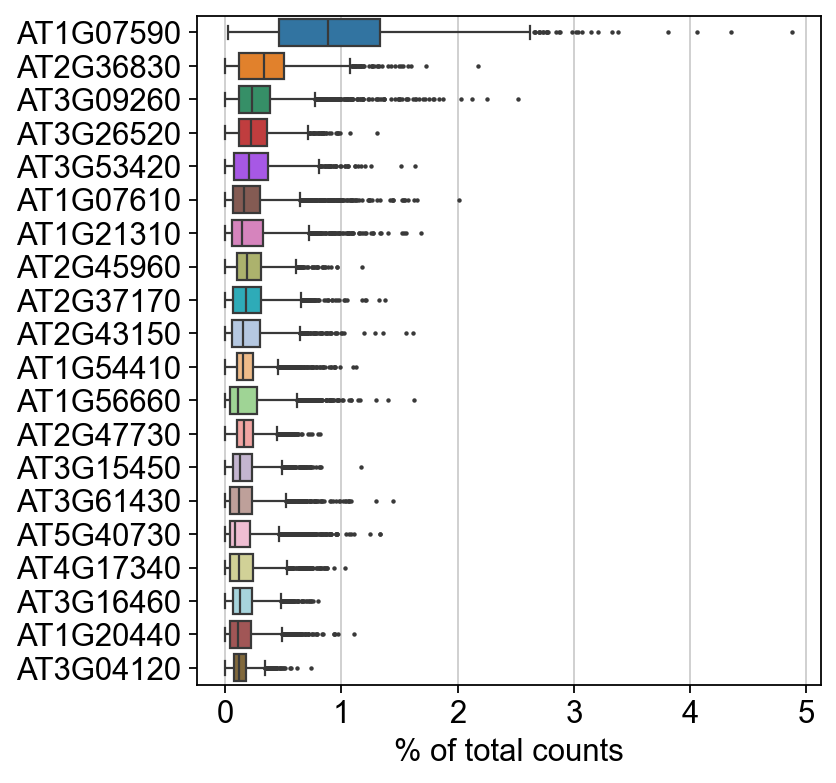

In [67]:
sc.pl.highest_expr_genes(
    adata, n_top=20
)  # Use builtin scanpy plotting function to visualize genes with the most reads

Lets take 5 minutes, everyone look up what the first gene does. If you can, look up where it tends to be localized (Suba can help with this). What might this indicate about the data?  Also look at the distribution of counts per cell and think about what that means. What is each dot on the graph? Now pick any After five minutes we will ask everyone what their gene does and if they think it makes sense to be so highly expressed. If you'd like, guess what the experimental treatment for this dataset was. 

This plots our most expressed genes, letting us get an idea if our experiment had anything go dramatically wrong. For example, if your most expressed genes were all stress genes, you might be concerned you mishandled cells prior to sequencing.

In a normal workflow, this might be where you peform background detection. Some RNA has a tendency to leak out of the cells/nuclei and into the ambient fluid. This ambient RNA then gets mixed with every cell's profile. This is especially problematic for marker detection, where broad detection of a gene might cause you to rule it out as a marker. For this, I would recommend CellBender or SoupX. CellBender is substantially more computationally intensive than SoupX. 


Before we keep going, we are going to remove cells and genes that we aren't interested in. For genes, we are only interested in genes that are in our dataset in at least a few cells, a gene in a single cell doesn't tell us much. We are also only interested in cells with enough reads to be able to cluster them. We might also remove genes with high mitochondrial signal (eg. the first gene) as this can indicate the cells are dying or low quality. 

In [68]:
sc.pp.filter_cells(
    adata, min_genes=min_genes_per_cell
)  # Filter cells with less than 1000 genes expressed
sc.pp.filter_genes(
    adata, min_cells=min_cells_per_gene
)  # Filter genes expressed in less than 5 cells

filtered out 181 cells that have less than 2000 genes expressed
filtered out 10718 genes that are detected in less than 5 cells


Now, lets explore our cleaned dataset

In [69]:
adata.obs

,sample,n_genes
AAACAGCCAACCGCCA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2593
AAACATGCACTTCATC-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2664
AAACATGCAGGCCATT-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2524
AAACCGCGTAACAGGG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,3340
AAACGCGCACCTGGTG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2183
...,...,...
TTGTTCCCACAAGCCT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,6187
TTTAACCTCGCTAAGT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,4004
TTTAGCAAGGACTAAG-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,2316
TTTCCGGGTGGAAGGC-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,2702


As you can see, we've trimmed out genes that weren't expressed in our data! We also trimmed some cells that have low expression. I will note that our cell threshold is quite high, as this data has already been preprocessed somewhat. We've also added some columns to our Pandas describing our cells and our genes. 



In [70]:
adata.var["mt"] = adata.var_names.str.startswith("AT1G07590")
# annotate the gene we identified as mitochondrial so we can remove it later

In [71]:
adata.var

,gene_symbols,n_cells,mt
AT1G30814,AT1G30814,6,False
AT1G78930,AT1G78930,22,False
AT1G71695,AT1G71695,49,False
AT1G56250,PP2-B14,37,False
AT1G69810,WRKY36,941,False
...,...,...,...
ATMG00513,ATMG00513,40,False
ATMG00730,ATMG00730,37,False
ATMG00080,rpl16,47,False
ATMG01000,ATMG01000,55,False


In [72]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)  ### This calculates several QC metrics all at once, based on what genes we feed in

In [73]:
adata.obs

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACAGCCAACCGCCA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2593,2590,4449.0,36.0,0.809171
AAACATGCACTTCATC-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2664,2663,4489.0,48.0,1.069281
AAACATGCAGGCCATT-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2524,2521,3984.0,36.0,0.903614
AAACCGCGTAACAGGG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,3340,3335,6646.0,70.0,1.053265
AAACGCGCACCTGGTG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2183,2180,3449.0,63.0,1.826616
...,...,...,...,...,...,...
TTGTTCCCACAAGCCT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,6187,6179,26487.0,27.0,0.101937
TTTAACCTCGCTAAGT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,4004,4004,8988.0,116.0,1.290610
TTTAGCAAGGACTAAG-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,2316,2313,4338.0,112.0,2.581835
TTTCCGGGTGGAAGGC-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,2702,2699,5817.0,29.0,0.498539


A peak at the metrics we calculated
The number of genes expressed in the count matrix - different because n_genes was calculated before filtering
The total counts per cell
The percentage of counts in mitochondrial genes
 now lets visualize them

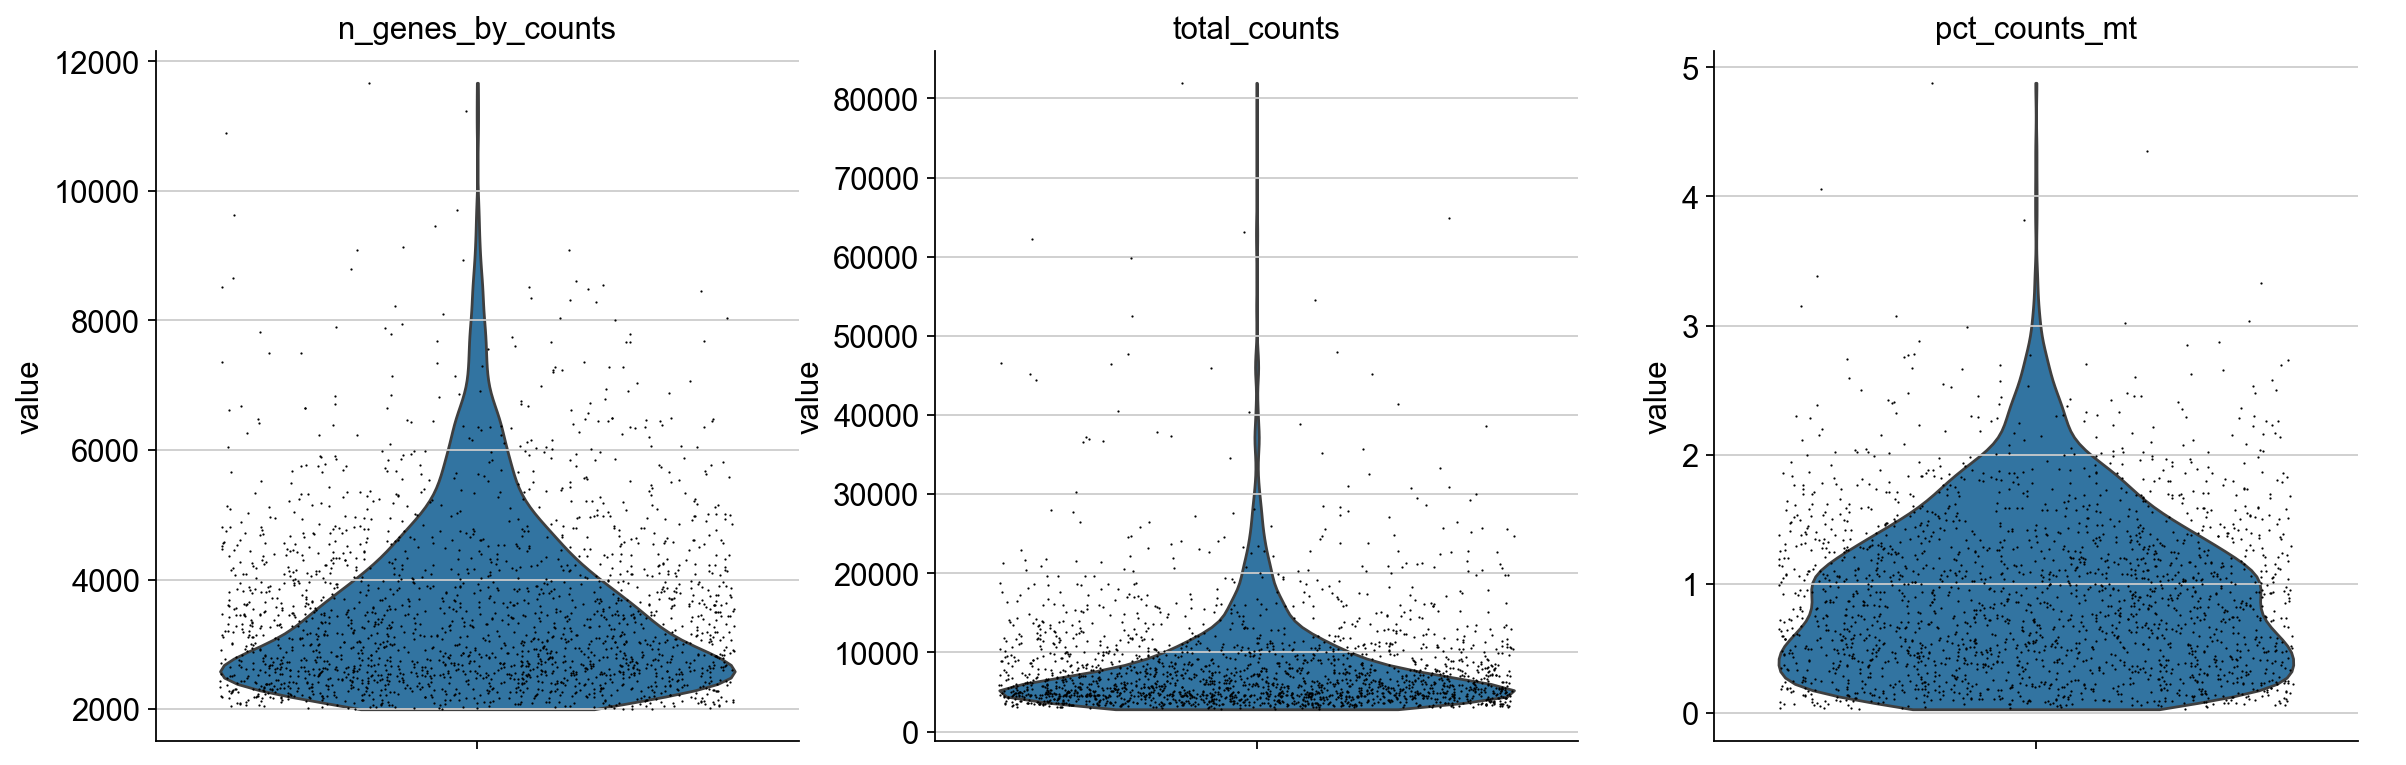

In [74]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)  ## Use built in plotting function to visualize the QC metrics we calculated

Now we want to remove genes with too many counts, as these could be droplets that got too many cells or another technical artifact. We also want to remove cells with too much mitochondrial DNA, as this indicates the cells are undergoing apoptosis. As an alternative to threshold based approaches, you might use a doublet detector like DoubletFinder or DoubletDetection.

In [75]:
adata = adata[
    adata.obs.n_genes_by_counts < max_different_genes_per_cell, :
]  ## Remove cells with more than 2500 counts (This is dated don't use this threshold on modern data)
adata = adata[
    adata.obs.pct_counts_mt < max_pct_counts_mt, :
]  # Remove cells with more than 5 % Mito reads

We've finished filtering, so we're gonna save our object at this step. It is important to save intermediate objects in case you have an issue with your pipeline and need to repair it later, or if you just want to re-do some analysis without running the entire thing. Changes to packages might happen that break code and you don't want to have to spend days getting it working again!


In [76]:
# adata.write(
#     "/write/pbmc3k_filtered.h5ad",
#     convert_strings_to_categoricals=False,
# )  # Making strings categories saves a lot of space!

Next we will normalize the data , and logarithmize it. 

In [77]:
sc.pp.normalize_total(
    adata, target_sum=1e4
)  ## Scale counts in each cell to sum to 10,000 for comparisons between cells

normalizing counts per cell
    finished (0:00:00)


/Users/michael/miniconda3/envs/Single_cell/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [78]:
sc.pp.log1p(
    adata
)  ## Log+1 transforms the data - this deals with zero counts since log(0) doesn't exist, without impacting rest of data

Now, to identify cell clusters we need to use genes that are different between cells. A gene that is expressed at the same level in every cell isn't useful for distinguishing them. So lets find our highly variable genes. 

In [79]:
sc.pp.highly_variable_genes(
    adata,
    min_mean=highly_variable_gene_min_mean,
    max_mean=highly_variable_gene_max_mean,
    min_disp=highly_variable_gene_min_disp,
)  # Identify highly variable genes based on mean and dispersion

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


This adds a lot of info to our .var, lets check it out. 

In [80]:
adata.var

,gene_symbols,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AT1G30814,AT1G30814,6,False,6,0.002874,99.712644,6.0,False,0.002673,0.771767,0.767187
AT1G78930,AT1G78930,22,False,22,0.011015,98.946360,23.0,False,0.013785,0.629507,0.290068
AT1G71695,AT1G71695,49,False,49,0.024904,97.653257,52.0,True,0.023354,1.226575,2.292543
AT1G56250,PP2-B14,37,False,37,0.024904,98.227969,52.0,False,0.024681,0.611386,0.229296
AT1G69810,WRKY36,941,False,941,0.848659,54.932950,1772.0,False,0.742751,0.833583,-0.103917
...,...,...,...,...,...,...,...,...,...,...,...
ATMG00513,ATMG00513,40,False,40,0.019157,98.084291,40.0,False,0.020486,0.222582,-1.074695
ATMG00730,ATMG00730,37,False,37,0.018678,98.227969,39.0,False,0.026117,0.562492,0.065312
ATMG00080,rpl16,47,False,47,0.025862,97.749042,54.0,False,0.033071,0.367975,-0.587066
ATMG01000,ATMG01000,55,False,55,0.028257,97.365900,59.0,False,0.030866,0.311951,-0.774963


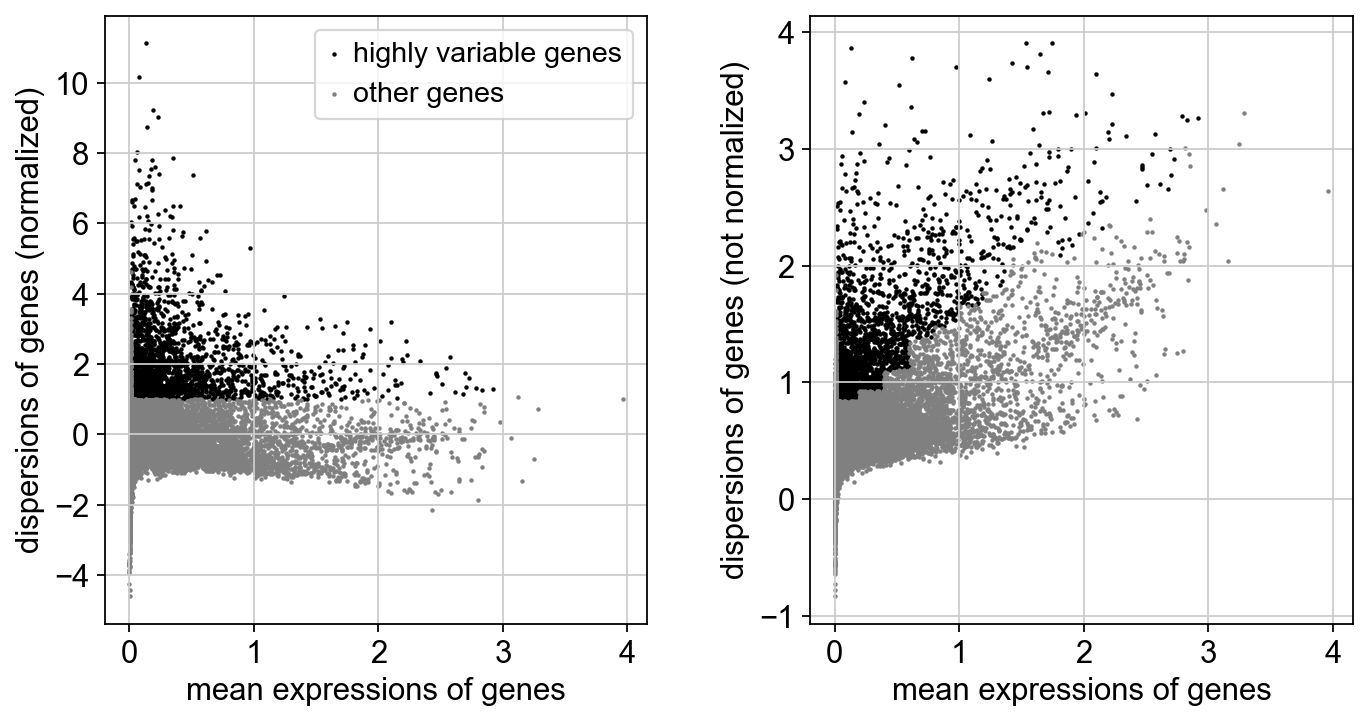

In [81]:
sc.pl.highly_variable_genes(
    adata
)  # Use Built in plotting function to visualize highly variable genes

Now that we've found our highly variable genes, lets begin to reduce the dimensionality of our data I'll explain PCA. We are going to skim over the nearest neighbors, as it is very intutitive. However, we will discuss UMAPs and their limitations as 2D projections of data. 

In [82]:
sc.pp.pca(
    adata, svd_solver="arpack", random_state=random_state
)  ## Identifies nearest neighbors of each cell based on PCA reduction

computing PCA
    with n_comps=50
    finished (0:00:00)


In [83]:
# sc.pl.pca_variance_ratio(adata) #Visualize contribution of PCAs to variance - uncomment if curious will not affect data

In [84]:
sc.pp.neighbors(
    adata,
    n_neighbors=number_of_neighbors,
    n_pcs=n_of_pca_components,
    random_state=random_state,
)  # Finds Distances in multidimensional space between cells

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [85]:
sc.tl.umap(
    adata, random_state=random_state
)  # Visualizes cells in multidimensional space as 2d embedding

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


In [86]:
sc.tl.leiden(
    adata, resolution=clustering_resolution, random_state=random_state
)  # Clusters cells by distance in multidimensional space

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [87]:
adata.obs

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACAGCCAACCGCCA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2593,2590,4449.0,36.0,0.809171,3
AAACATGCAGGCCATT-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2524,2521,3984.0,36.0,0.903614,3
AAACGCGCAGGATTAA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2954,2953,5404.0,23.0,0.425611,1
AAACGGATCACATTGA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,5719,5719,15484.0,78.0,0.503746,2
AAAGGACGTGATTACG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,3259,3258,7080.0,31.0,0.437853,8
...,...,...,...,...,...,...,...
TTCAGGTAGCCAGGTC-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,3087,3086,5469.0,28.0,0.511977,3
TTCAGGTAGCGTGCGT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,3434,3433,7803.0,15.0,0.192234,4
TTCATCCCACCAGCAT-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,4781,4779,14560.0,22.0,0.151099,4
TTTCCGGGTGGAAGGC-1_SRR24921612_Athaliana_control-rep1_filtered,SRR24921612_Athaliana_control-rep1_filtered,2702,2699,5817.0,29.0,0.498539,0


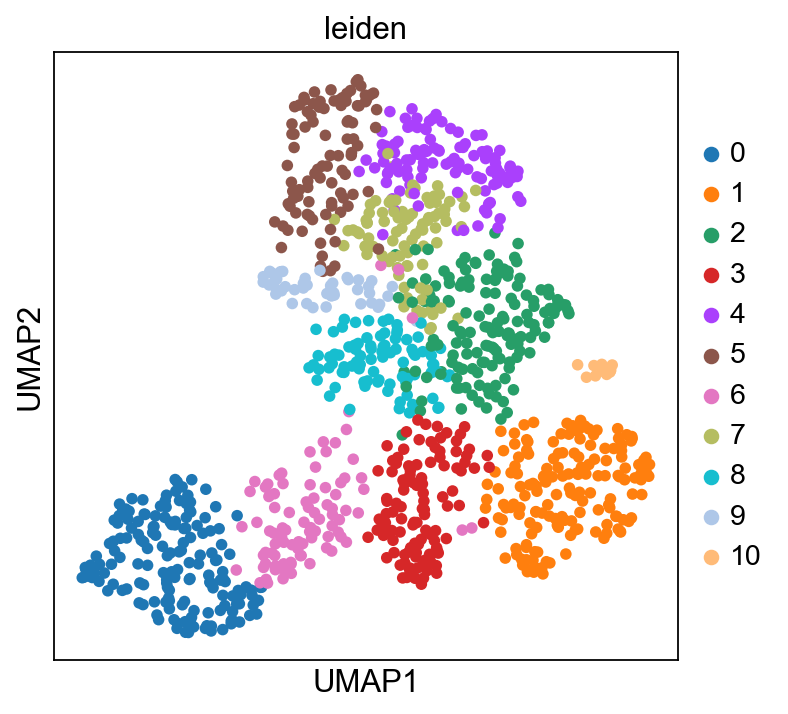

In [88]:
sc.pl.umap(adata, color=["leiden"])  # Visiualize Clustering

Before we go on, lets take 10 minutes to play with the clustering settings and see how things change. Try changing resolution, n_neighbors, and n_pca one at a time and see how it changes the data. Do it one and a time and then in combination. Also try changing the highly variable gene selection cut offs. 

In [89]:
adata.write(
    "/write/pbmc3k_clustered.h5ad",
    convert_strings_to_categoricals=False,
)  # We are saving our object again after clustering

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/write/pbmc3k_clustered.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

Now lets try and identify one of the clusters, using 3 markers for root cortex cells

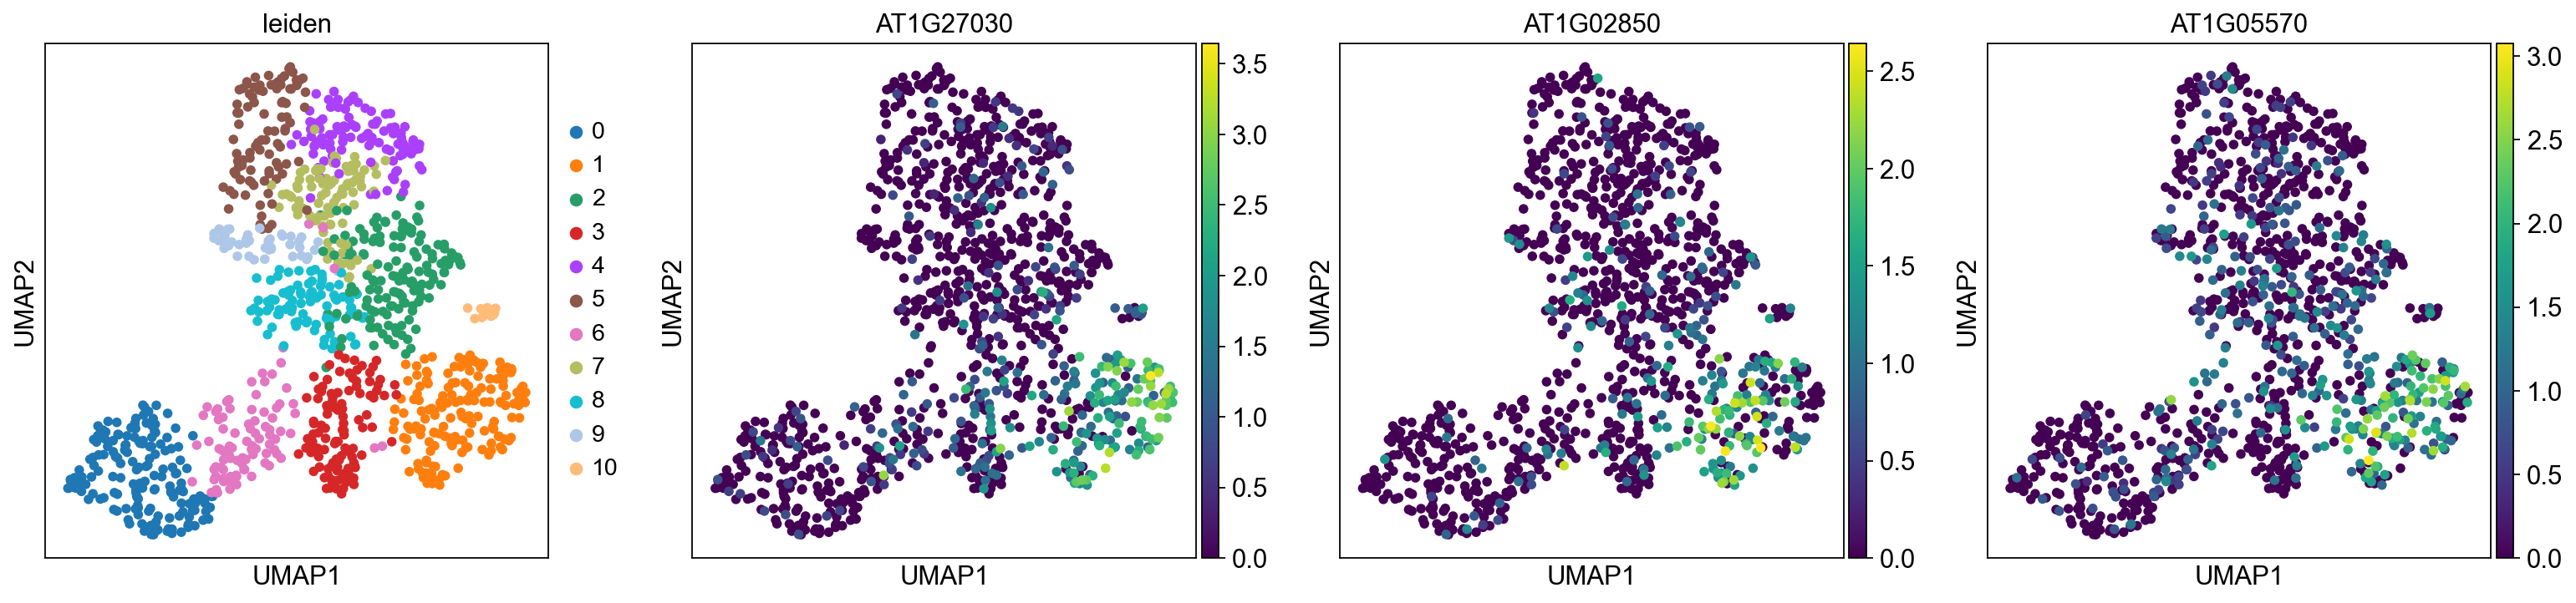

In [90]:
sc.pl.umap(
    adata, color=["leiden", "AT1G27030", "AT1G02850", "AT1G05570"]
)  # Visualize clustering and Attempt to Identify B Cells By expression

Now lets take 5 minutes and let everyone plot some genes on their own. You can takes genes from above, where we looked at the most expressed genes, or pick genes that you know or like. Plot a couple of genes on your own!

In [93]:
sc.pl.umap(
    adata, color=["#####", "#####", "#####"]
)  # shows embedding with cells colored by expression of 3 marker genes

KeyError: 'Could not find key ##### in .var_names or .obs.columns.'

<Figure size 1404x400 with 0 Axes>

In [92]:
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [94]:
new_cluster_names = {"1": "Cortex"}
adata.obs["leiden"] = adata.obs["leiden"].replace(
    new_cluster_names
)  ## Replace the cluster name

/var/folders/nk/6xkk9sgn1pz4ff1b36sfq3y40000gt/T/ipykernel_39671/1138046419.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["leiden"] = adata.obs["leiden"].replace(


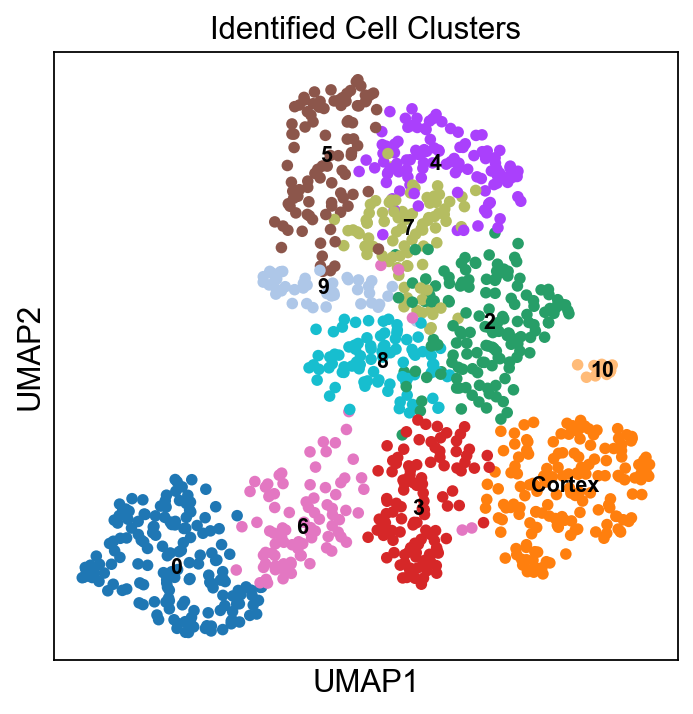

In [95]:
sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="on data",
    legend_fontsize="x-small",
    title="Identified Cell Clusters",
)

Now that we have clusters, we can do things like find marker genes, ID cell types, and do differential gene expression. 

One key tool to understand is psuedobulking data. Psuedobulking helps handle the sparsity of single-cell data while also being more intuitive to handle statistically. If you want to compare two cell types, you might think to treat each cell as a sample, and do your statistics that way. However, this would provide you with dramatically more confidence in your estimate than is real, as the cells in a cluster are not independent. Instead, we psuedobulk, allowing us to reduce sparsity and reduce the cells to true idependent samples, based on batch. 

First, we're going to create some fake batches and assign cells to them

In [96]:
adata.obs["Batch"] = np.random.randint(
    low=1, high=4, size=len(adata.obs)
)  # Assign random batches - do you know why high is 4?
adata.obs.head(40)

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,Batch
AAACAGCCAACCGCCA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2593,2590,4449.0,36.0,0.809171,3,2
AAACATGCAGGCCATT-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2524,2521,3984.0,36.0,0.903614,3,2
AAACGCGCAGGATTAA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2954,2953,5404.0,23.0,0.425611,Cortex,2
AAACGGATCACATTGA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,5719,5719,15484.0,78.0,0.503746,2,2
AAAGGACGTGATTACG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,3259,3258,7080.0,31.0,0.437853,8,1
AAATGCCTCATGACCG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,4655,4653,10516.0,25.0,0.237733,2,2
AAATGGCCAGCATTAT-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2479,2476,4071.0,28.0,0.687792,2,2
AACAGCAAGTAAGTGG-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,2548,2547,4292.0,37.0,0.862069,9,2
AACATTGTCTTGATGA-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,4979,4977,11858.0,98.0,0.826446,Cortex,1
AAGACCAAGATAACCC-1_SRR24921619_Athaliana_case-rep2_filtered,SRR24921619_Athaliana_case-rep2_filtered,3911,3910,9210.0,30.0,0.325733,2,3


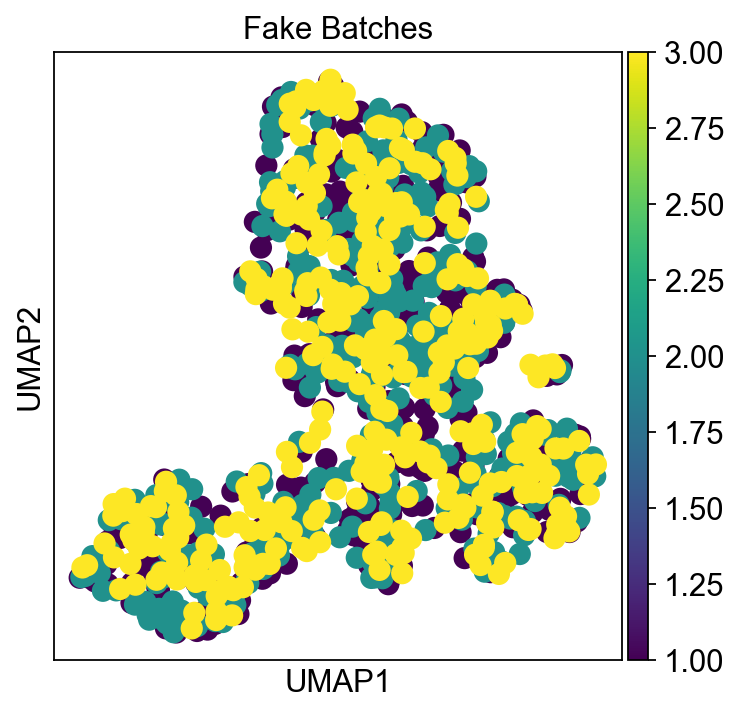

In [97]:
sc.pl.umap(
    adata, color="Batch", legend_fontsize="x-small", title="Fake Batches", s=400
)  # Notice the overplotting when using the batch as an integer!

In [98]:
adata.obs["Batch Str"] = adata.obs["Batch"].astype(
    str
)  # Change the batch type to string

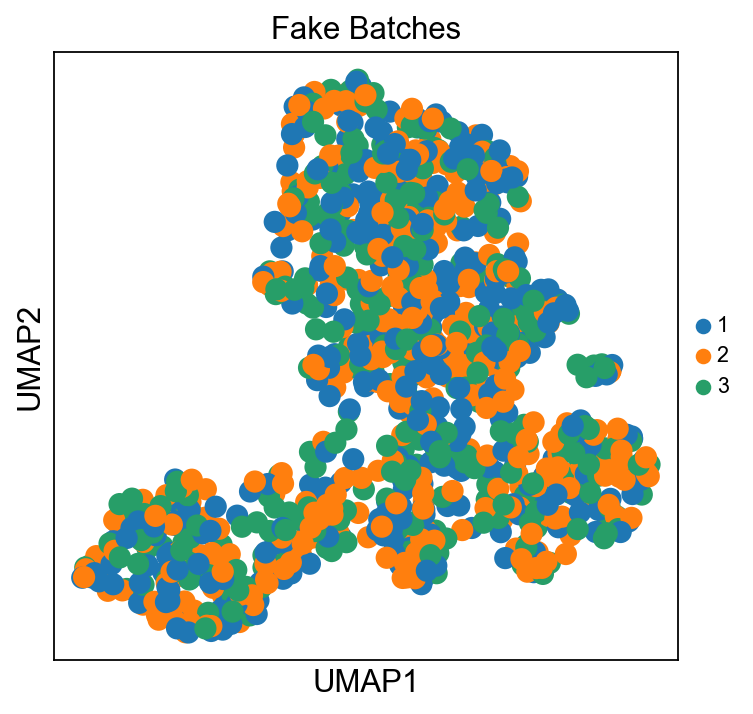

In [99]:
sc.pl.umap(
    adata, color="Batch Str", legend_fontsize="x-small", title="Fake Batches", s=400
)  # overplotting resolved! Think of this when plotting a metadata variable on single cell data

Now we will loop through the batches and build a dataframe. Note that this code assumes all clusters contain all batches - This might not be true!

In [108]:
clusters = adata.obs["leiden"].unique()  # Get cluster names
batches = adata.obs["Batch"].unique()  # Get batch IDs
all_samples = list(
    itertools.product(clusters, batches)
)  # Generate list of all combinations of the above

In [109]:
all_samples

[('3', np.int64(2)),
 ('3', np.int64(1)),
 ('3', np.int64(3)),
 ('Cortex', np.int64(2)),
 ('Cortex', np.int64(1)),
 ('Cortex', np.int64(3)),
 ('2', np.int64(2)),
 ('2', np.int64(1)),
 ('2', np.int64(3)),
 ('8', np.int64(2)),
 ('8', np.int64(1)),
 ('8', np.int64(3)),
 ('9', np.int64(2)),
 ('9', np.int64(1)),
 ('9', np.int64(3)),
 ('6', np.int64(2)),
 ('6', np.int64(1)),
 ('6', np.int64(3)),
 ('5', np.int64(2)),
 ('5', np.int64(1)),
 ('5', np.int64(3)),
 ('0', np.int64(2)),
 ('0', np.int64(1)),
 ('0', np.int64(3)),
 ('7', np.int64(2)),
 ('7', np.int64(1)),
 ('7', np.int64(3)),
 ('10', np.int64(2)),
 ('10', np.int64(1)),
 ('10', np.int64(3)),
 ('4', np.int64(2)),
 ('4', np.int64(1)),
 ('4', np.int64(3))]

In [110]:
psuedobulk_df = pd.DataFrame(
    index=adata.var_names
)  ## Make a base dataframe index we will add stuff on to later
psuedobulk_df

""
AT1G30814
AT1G78930
AT1G71695
AT1G56250
AT1G69810
...
ATMG00513
ATMG00730
ATMG00080
ATMG01000


In [111]:
for batch_type in all_samples:

    ## Read in the Names so our code is easy to understand
    current_cluster = batch_type[0]
    current_batch = batch_type[1]

    ## Calculate the Psuedobulked mean
    cells_matching_batch_and_cluster = adata[
        (adata.obs["leiden"] == current_cluster) & (adata.obs["Batch"] == current_batch)
    ]
    mean_of_genes = cells_matching_batch_and_cluster.X.mean(axis=0).tolist()[0]

    name_of_combo = (
        "Cluster number " + current_cluster + " " + "Batch Number " + str(current_batch)
    )
    psuedobulk_df[name_of_combo] = mean_of_genes

In [112]:
adata.write(
    "/Users/michael/Data/Junk_data/pbmc3k_final.h5ad",
    convert_strings_to_categoricals=False,
)  # Save our final object!

In [113]:
psuedobulk_df.head(10)

,Cluster number 3 Batch Number 2,Cluster number 3 Batch Number 1,Cluster number 3 Batch Number 3,Cluster number Cortex Batch Number 2,Cluster number Cortex Batch Number 1,Cluster number Cortex Batch Number 3,Cluster number 2 Batch Number 2,Cluster number 2 Batch Number 1,Cluster number 2 Batch Number 3,Cluster number 8 Batch Number 2,...,Cluster number 0 Batch Number 3,Cluster number 7 Batch Number 2,Cluster number 7 Batch Number 1,Cluster number 7 Batch Number 3,Cluster number 10 Batch Number 2,Cluster number 10 Batch Number 1,Cluster number 10 Batch Number 3,Cluster number 4 Batch Number 2,Cluster number 4 Batch Number 1,Cluster number 4 Batch Number 3
AT1G30814,0.000000,0.000000,0.000000,0.021179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AT1G78930,0.000000,0.000000,0.000000,0.020596,0.000000,0.020343,0.009282,0.014378,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AT1G71695,0.000000,0.020162,0.000000,0.019827,0.000000,0.018764,0.000000,0.000000,0.016740,0.015802,...,0.016976,0.019847,0.021159,0.000000,0.000000,0.000000,0.000000,0.023003,0.033167,0.000000
AT1G56250,0.051019,0.048266,0.075922,0.000000,0.000000,0.016920,0.052593,0.000000,0.000000,0.000000,...,0.000000,0.015069,0.000000,0.013823,0.000000,0.000000,0.000000,0.000000,0.000000,0.022873
AT1G69810,0.167328,0.060997,0.181364,0.356145,0.400933,0.374793,0.389838,0.702360,0.751687,0.357258,...,0.877762,0.706310,0.819352,0.692424,0.592418,0.194290,0.223472,0.607524,0.576111,0.661380
AT1G72450,0.329328,0.364276,0.433214,1.190718,1.265563,1.110733,0.198140,0.246642,0.065628,0.089737,...,0.175895,0.164980,0.172558,0.070590,0.000000,0.000000,0.000000,0.070032,0.020196,0.106343
AT1G76280,0.129928,0.120682,0.081288,0.064824,0.101943,0.084983,0.130086,0.028879,0.075529,0.121207,...,0.043525,0.177960,0.096183,0.083588,0.000000,0.000000,0.000000,0.045659,0.031862,0.153136
AT1G15210,0.673221,0.606707,0.742110,0.567086,0.563208,0.585367,0.996493,0.981581,1.063117,0.656958,...,0.470283,0.930851,0.818880,0.818635,1.030309,1.077698,0.743837,0.807311,1.032677,1.128033
AT1G15250,0.041492,0.248466,0.185431,0.084401,0.184522,0.120282,0.191367,0.216780,0.218154,0.704265,...,0.073451,0.278561,0.229476,0.308409,0.000000,0.000000,0.414002,0.142708,0.130578,0.090576
AT1G79700,0.123519,0.293397,0.169175,0.113823,0.025801,0.036684,0.126931,0.123618,0.051258,0.111198,...,0.081928,0.101878,0.147678,0.263832,0.000000,0.000000,0.000000,0.253431,0.176605,0.127867
